In [6]:
import warnings
warnings.filterwarnings("ignore")

## 선형회귀

### 정규방정식으로 모델 파라미터 최적값 찾기

In [2]:
import numpy as np
X = 2 * np.random.rand(100,1) #균일분포 난수
y = 4+3*X+np.random.randn(100,1) #표준정규분포 난수

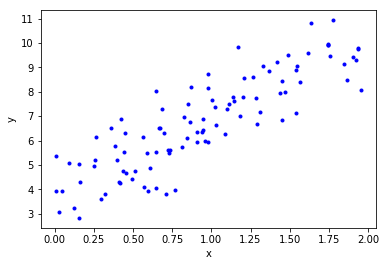

In [8]:
import matplotlib.pyplot as plt
plt.plot(X,y, "b.")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

In [13]:
X_b = np.c_[np.ones((100,1)), X]
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)

In [14]:
theta_best

array([[3.79711114],
       [3.16502787]])

In [17]:
X_new = np.array([[0],[2]])
X_new_b = np.c_[np.ones((2,1)), X_new]
y_predict = X_new_b.dot(theta_best)
y_predict # y=3x+잡음 이므로 원하는 예측값은 차례대로 4, 11

array([[ 3.79711114],
       [10.12716689]])

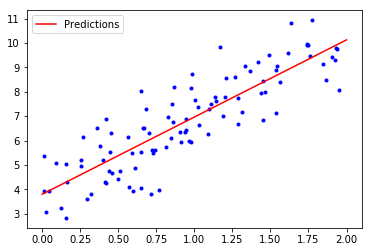

In [30]:
plt.plot(X,y,"b.")
plt.plot(X_new, y_predict, "r-", label="Predictions")
plt.legend()
plt.show()

### 최소제곱으로 모델 파라미터 최적값 찾기
- 사이킷런에서 최소제곱을 기반으로 한다.
- 최소제곱에서 최적theta = pinv(X).dot(y) (단, pinv()는 유사역행렬을 구하는 함수)
- X.T.dot(X)의 역행렬이 존재하지 않을 경우 정규방정식을 사용할 수 없지만
- 유사역행렬(=Moore penrose역행렬)은 항상 존재하기 때문에 최적theta값을 항상 구할 수 있다. 또한 계산도 간단함

In [31]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [32]:
lin_reg.intercept_, lin_reg.coef_ 

(array([3.79711114]), array([[3.16502787]]))

In [33]:
lin_reg.predict(X_new)

array([[ 3.79711114],
       [10.12716689]])

In [34]:
theta_best_svd, residuals, rank, s = np.linalg.lstsq(X_b, y, rcond=1e-6)
theta_best_svd

array([[3.79711114],
       [3.16502787]])

In [35]:
np.linalg.pinv(X_b).dot(y) #유사역행렬으로 theta값 구하기

array([[3.79711114],
       [3.16502787]])

정규방정식과 SVD를 통해 선형회귀의 최적 파라미터를 찾는 방법은 
- **특성 수가 많아지면 학습이 오래 걸림**
- 샘플 수에 대해서는 선형
- 예측에 대해서는 특성 수, 샘플 수 모두 선형적으로 증가

특성 수가 많을 때 아래 GD를 사용한다.

## 경사하강법(Gradient Descent)

### full gradient descent(=batch GD)
매 스텝에서 전체 훈련셋을 사용해 gradient를 계산함. -> 느림

In [36]:
# gradient descent 구현
learning_rate = 0.1
n_iterations = 1000 #움직이는 횟수
m=100 #샘플수

theta = np.random.randn(2,1) #random initialization

for iteration in range(n_iterations):
    gradients = 2/m * X_b.T.dot(X_b.dot(theta)-y)
    theta = theta - learning_rate * gradients

theta

array([[3.79711114],
       [3.16502787]])

learning rate, n_iterations 설정
- learning rate : grid search. 단 반복 횟수 제한
- n_iterations : gradient vector가 아주 작아지면 중지

### 확률적(=무작위) 경사 하강법(stochastic gradient descnet, SGD)
매 스텝에서 무작위로 선택된 하나의 샘플데이터로 gradient를 계산함.

- 무작위성은 local minimum을 벗어날 수 있지만 global minimum에 다다르지 못할 가능성이 있다. 
- -> simulated annealing
- 시작할 때 학습률을 크게 하고, 점진적으로 줄여나감. 학습률을 결정하는 함수를 learning schedule이라고 한다.

In [38]:
n_epochs = 50
t0, t1 = 5,50

def learning_schedule(t):
    return t0 / (t+t1)

theta = np.random.randn(2,1)

for epoch in range(n_epochs):
    for i in range(m):
        random_idx = np.random.randint(m) #복원추출을 하는데, 모든 샘플을 학습시키는 것보다 일찍 수렴하는 경향이 있음.
        xi = X_b[random_idx:random_idx+1]
        yi = y[random_idx:random_idx+1]
        gradients = 2*xi.T.dot(xi.dot(theta)-yi)
        learning_rate = learning_schedule(epoch*m +i)
        theta = theta - learning_rate*gradients
        
theta

array([[3.77437889],
       [3.10856584]])

In [42]:
from sklearn.linear_model import SGDRegressor

sgd_reg = SGDRegressor(max_iter = 1000, tol=1e-3, penalty=None, eta0=0.1) #max_iter : 최대 epoch, tol: tolerance. 그레디언트 벡터의 norm, eta0: learning rate.
sgd_reg.fit(X, y.ravel()) # np.ravel() : 다차원 배열을 1차원으로 풀어줌.

SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.1, fit_intercept=True, l1_ratio=0.15,
             learning_rate='invscaling', loss='squared_loss', max_iter=1000,
             n_iter_no_change=5, penalty=None, power_t=0.25, random_state=None,
             shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,
             warm_start=False)

In [43]:
sgd_reg.intercept_, sgd_reg.coef_

(array([3.81522366]), array([3.19716347]))

### mini-batch gradient descent
- GPU를 사용한 성능 향상
- full GD 보다 시간은 덜 걸리고, SGD보다 덜 불규칙하다는 장점.

## 다항회귀

In [64]:
m=100
X = 6*np.random.rand(m,1)-3
y = 0.5 * X**2 + X + 2 + np.random.randn(m,1)

In [65]:
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)
X[0], X_poly[0]

(array([0.531834]), array([0.531834  , 0.28284741]))

In [74]:
poly_features.get_feature_names()

['x0', 'x0^2']

In [66]:
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_

(array([1.97100411]), array([[0.97707136, 0.51600607]]))

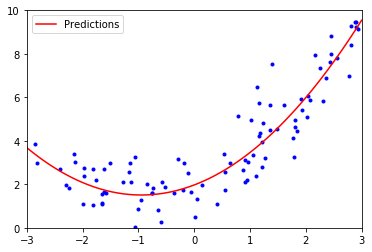

In [71]:
X_new = np.linspace(-3,3,100).reshape(100,1)
X_new_poly = poly_features.transform(X_new)
y_new = lin_reg.predict(X_new_poly)
plt.plot(X, y, "b.")
plt.plot(X_new, y_new, "r-", label="Predictions")
plt.legend()
plt.axis([-3,3,0,10])
plt.show()

## 학습 곡선
모델이 과소적합되었는지, 과대적합되었는지 알아보는 방법
- 교차 검증 : 훈련 데이터의 성능은 좋으나 교차 검증 점수가 나쁜 경우 overfitting
- 학습 곡선 

## 규제가 있는 선형 모델

## 로지스틱 회귀